In [1]:
import dataset
import matplotlib.pyplot as plt
import tree_search
import numpy as np
import sympy
sympy.init_printing()

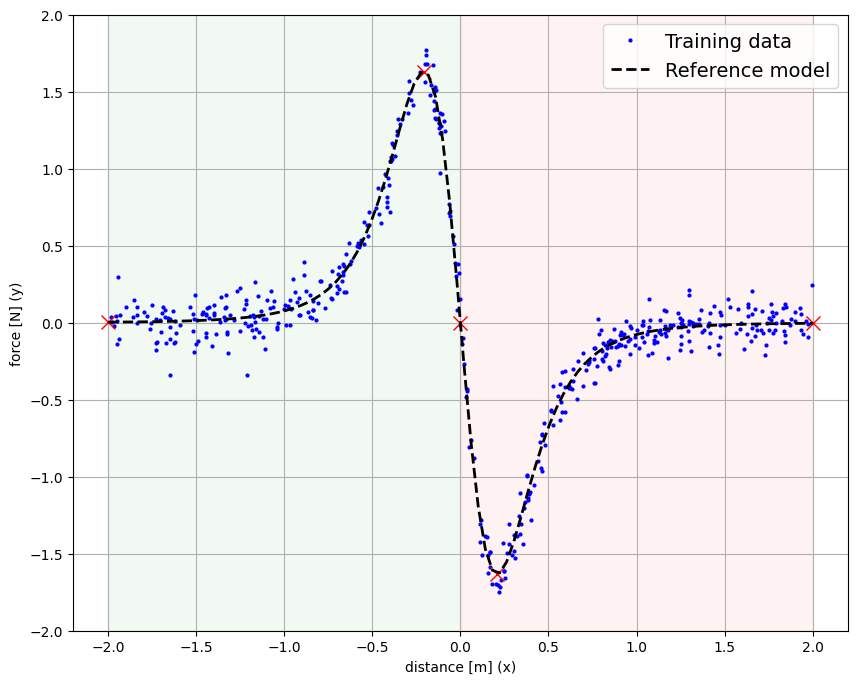

In [2]:
S = dataset.MagmanDatasetScaled()
S.sample(size=500, noise=0.05, mesh=False)
#S.load('data/magman.csv')
#S.erase(-0.3, 0.3)
S.plot()

In [3]:
#avg, std = tree_search.compute_smoothness(S)
#print(f"Avg: {avg}\nStd: {std}")

In [4]:
"""from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.optimize import minimize

class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=len(S.data), n_obj=1, xl=S.yl, xu=S.yu)

    def _evaluate(self, x, out, *args, **kwargs):
        evals = []
        for sol in x:
            slopes = []
            n = len(sol)
            for i in range(1, n):
                beta_i   = math.log(S.data[i].y, sol[i])
                beta_i_1 = math.log(S.data[i - 1].y, sol[i - 1])
                slopes.append( (beta_i - beta_i_1) / (1) )
                slopes.append( (sol[i] - sol[i-1]) / (1) )
            evals.append(np.std(slopes))
        
        out["F"] = np.row_stack(evals)

algorithm = ES(n_offsprings=200, pop_size=50)

res = minimize(MyProblem(),
               algorithm,
               ("n_gen", 5000),
               seed=1,
               verbose=False)

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))"""

'from pymoo.core.problem import Problem\nfrom pymoo.algorithms.soo.nonconvex.es import ES\nfrom pymoo.optimize import minimize\n\nclass MyProblem(Problem):\n\n    def __init__(self):\n        super().__init__(n_var=len(S.data), n_obj=1, xl=S.yl, xu=S.yu)\n\n    def _evaluate(self, x, out, *args, **kwargs):\n        evals = []\n        for sol in x:\n            slopes = []\n            n = len(sol)\n            for i in range(1, n):\n                beta_i   = math.log(S.data[i].y, sol[i])\n                beta_i_1 = math.log(S.data[i - 1].y, sol[i - 1])\n                slopes.append( (beta_i - beta_i_1) / (1) )\n                slopes.append( (sol[i] - sol[i-1]) / (1) )\n            evals.append(np.std(slopes))\n        \n        out["F"] = np.row_stack(evals)\n\nalgorithm = ES(n_offsprings=200, pop_size=50)\n\nres = minimize(MyProblem(),\n               algorithm,\n               ("n_gen", 5000),\n               seed=1,\n               verbose=False)\n\nprint("Best solution found: \

In [5]:
#alphas, betas, _, _ = tree_search.infer_operator(S, opt='pow')
#print(alphas)
#print(betas)

"""import sympy
x = sympy.Symbol("x")
res = sympy.nsolve((x ** 2) + 1, x, 23, verify=False)
print(res)"""

"""alphas, betas = tree_search.infer_operator_slq_optimz(S, opt='sum')
print("___SOLUTION___")
print(alphas)
print(betas)"""

stree, data_tuning_report, knowledge_tuning_report = tree_search.infer_syntaxtree(S, max_degree=6, max_degree_inner=1, max_depth=3, trials=150)
print(f"\nData Root found:    {data_tuning_report['root_found']}")
print(f"Data MSE:             {data_tuning_report['mse']}")
print(f"Data R2:              {1 - (data_tuning_report['sse'] / S.sst)}")
print(f"Knowledge Root found: {knowledge_tuning_report['root_found']}")
print(f"Knowledge MSE:        {knowledge_tuning_report['mse']}")
if stree is not None: print(stree.tostring())

TREE FOUND
TREE FOUND
TREE FOUND

Data tuning (avg time):      0 ms
Knowledge tuning (avg time):   0 ms
Data tuning (total time):      4456 ms
Knowledge tuning (total time): 3482 ms

Get system (avg time): 0 ms
Get system (total time): 7367 ms
Get system (total calls): 50944

Setcoeffs (total time): 104 ms

Data Root found:    False
Data MSE:             0.03287717757944228
Data R2:              0.9210666986644799
Knowledge Root found: False
Knowledge MSE:        1.8928075394019523e-06
P_a(x)/P_b(x)


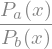

In [6]:
sympy.parse_expr(stree.tostring(), evaluate=False)

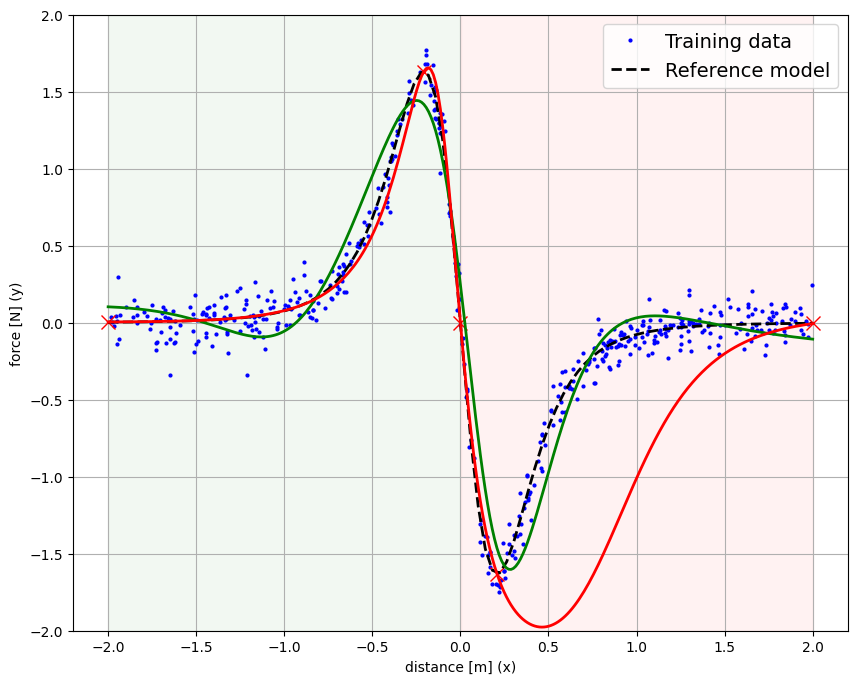

In [7]:
S.plot()
n = len(S.data)

x = np.linspace(S.xl, S.xu, 300)

stree.set_coeffs(data_tuning_report['sol'].tolist())
plt.plot(x, stree.evaluate(x), linestyle='solid', linewidth=2, color='green', label='Data model');

stree.set_coeffs(knowledge_tuning_report['sol'].tolist())
plt.plot(x, stree.evaluate(x), linestyle='solid', linewidth=2, color='red',   label='Knowledge model');

#plt.ylim(( min(min(alphas), min(betas)), max(max(alphas), max(betas)) ))

#for dp in inter_points:
#    plt.plot(dp.x, dp.y, 'o', markersize=8, label='inter_point')
#    print(f"{dp.x}, {dp.y}")